In [118]:
from transformers import DetrFeatureExtractor, DetrForObjectDetection
from PIL import Image, ImageDraw
import PIL
import os
import pandas as pd
import numpy as np
from transformers import __version__
import typing
from torchvision.utils import draw_bounding_boxes

In [2]:
def gather_data(path: str) -> pd.DataFrame:
    image_ids = []
    bbox_left = []
    bbox_top = []
    bbox_right = []
    bbox_bottom = []
    classes = []

    for item in os.listdir(path + "/image"): # look at every image in path
        image_id = item.split(".")[0] # split on file extension and just get id
        
        with open(f"{path}/label/{image_id}.txt", "r") as f:
            for line in f.readlines():
                split_line = line.split(" ")
                
                image_ids.append(image_id)

                # each bbox is defined as (class left top right bottom) as a new line in the corresponding .txt file

                classes.append(split_line[0].strip())
                bbox_left.append(split_line[1].strip())
                bbox_top.append(split_line[2].strip())
                bbox_right.append(split_line[3].strip())
                bbox_bottom.append(split_line[4].strip("\n"))

    df = pd.DataFrame(data={
        "image_id": image_ids,
        "bbox_left": bbox_left,
        "bbox_top": bbox_top,
        "bbox_right": bbox_right,
        "bbox_bottom": bbox_bottom,
        "class": classes
    })

    return df

In [3]:
df = gather_data("crowd4access-images/crowd4access-images/trainval")
df.head()

,image_id,bbox_left,bbox_top,bbox_right,bbox_bottom,class
0,jiYLJwXmVXuZKQA9N6O7v3,515,288,835,438,tactile_surface
1,0q6mFPlnqbVkUG1azCIcnA,447,431,685,491,tactile_surface
2,0q6mFPlnqbVkUG1azCIcnA,719,412,819,432,tactile_surface
3,hbcZ1FfLcwudenW4PLHJ9h,731,288,1017,431,tactile_surface
4,nA4vzxw0BdqNTRHk1G9Qjw,456,277,642,336,tactile_surface


In [153]:
def draw_example(index: int) -> Image:
    filename = df["image_id"][index]
    image = Image.open(f"crowd4access-images/crowd4access-images/trainval/image/{filename}.jpg")

    draw = ImageDraw.Draw(image, "RGBA")

    left = float(df["bbox_left"][index])
    top = float(df["bbox_top"][index])
    right = float(df["bbox_right"][index])
    bottom = float(df["bbox_bottom"][index])

    draw.rectangle([(right, top), (left, bottom)])
    draw.text(
        (100, 100), 
        f"{str(left)}\n{str(top)}\n{str(right)}\n{str(bottom)}\n", 
        fill="red",
        size=24)

    return image

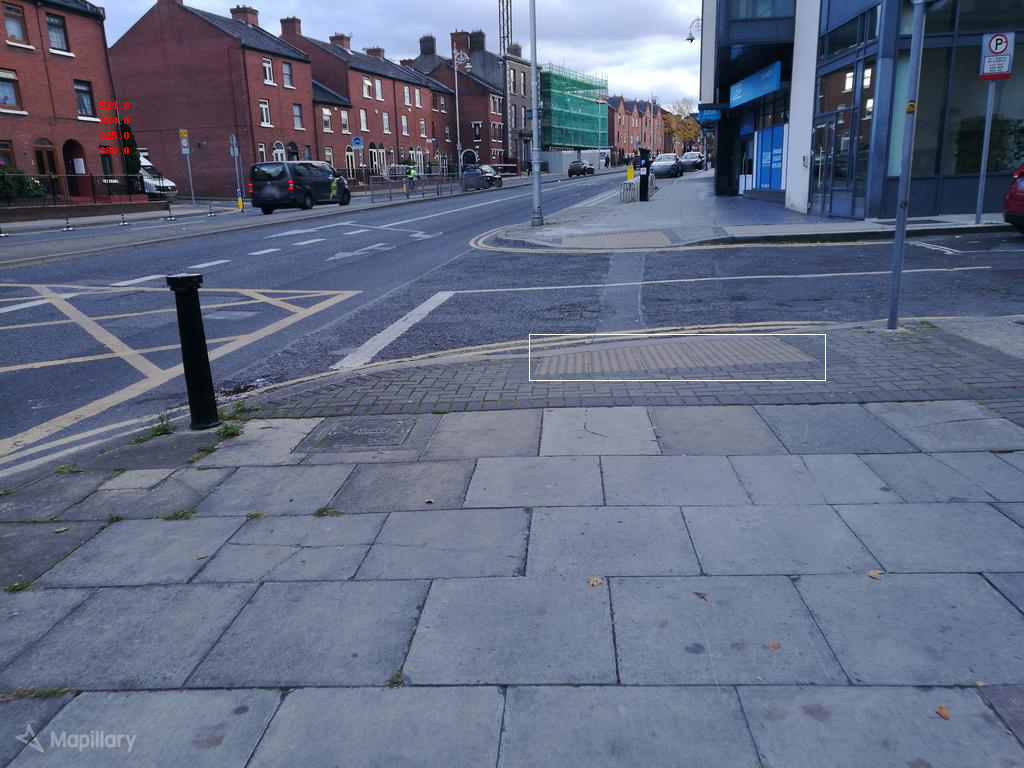

In [154]:
draw_example(np.random.randint(0, df.shape[0]))

For the model I want to use (facebook/detr-resnet-50) from Hugging Face, it requires the annotations to be in the format:
```
{"image_id": int,
"annotations": List[Dict]}
```
with each Dict being a COCO object annotation

In [161]:
def convert_bbox_definition(left: int, top: int, right: int, bottom: int) -> list:
    '''
    Converts bounding box definition from:
    
    `class_name top_left_x top_left_y bottom_right_x bottom_right_y`

    to the proper COCO formatting defined as:

    `top_left_x top_left_y width height`

    '''
    top_left_x = left
    top_left_y = top
    width = right - left
    height = bottom - top

    bbox = [top_left_x, top_left_y, width, height]
    return bbox

In [162]:
def convert2coco(path: str) -> typing.Union[PIL.Image.Image, dict]:
    '''
    Creates the correct label formatting for the model to train on defined as a dictionary with keys `image_id` and `annotations` where `annotations` is a list of dictionaries with each dictionary being a COCO object annotation
    '''

    d = {
        "image_id": [],
        "annotations": []
    }
    images = []

    i = 0 # counter for creating new image ids
    j = 0 # counter for annotation ids

    for item in os.listdir(path + "/image"): # look at every image in path
        image = Image.open(path + "/image/" + item)
        images.append(image)

        d["image_id"].append(i)

        filename = item.split(".")[0] # split on file extension and just get id
        
        with open(f"{path}/label/{filename}.txt", "r") as f:
            for line in f.readlines():
                split_line = line.split(" ")
                
                # each bbox is defined as (class left top right bottom) as a new line in the corresponding .txt file

                image_class = split_line[0].strip()
                bbox_left = int(split_line[1].strip())
                bbox_top = int(split_line[2].strip())
                bbox_right = int(split_line[3].strip())
                bbox_bottom = int(split_line[4].strip("\n"))

                new_bbox = convert_bbox_definition(
                    bbox_left,
                    bbox_top,
                    bbox_right,
                    bbox_bottom
                )

                unique_coco_annotation = {
                    "image_id": i,
                    "bbox": new_bbox,
                    "id": j
                }

                d["annotations"].append(unique_coco_annotation)
                
                j += 1

        i += 1
    return images, d

In [163]:
images, annotations = convert2coco("crowd4access-images/crowd4access-images/trainval")

Let's check to make sure annotations are properly formatted and in the correct order.

In [181]:
def draw_bbox(image: PIL.Image.Image, annotation_bboxes: list) -> PIL.Image.Image:

    draw = ImageDraw.Draw(image, "RGBA")

    for item in annotation_bboxes:

        box = item["bbox"]

        top_left_x = box[0]
        top_left_y = box[1]
        width = box[2]
        height = box[3]

        draw.rectangle([
            (top_left_x, top_left_y), 
            (top_left_x + width, top_left_y + height)
            ])

    return image

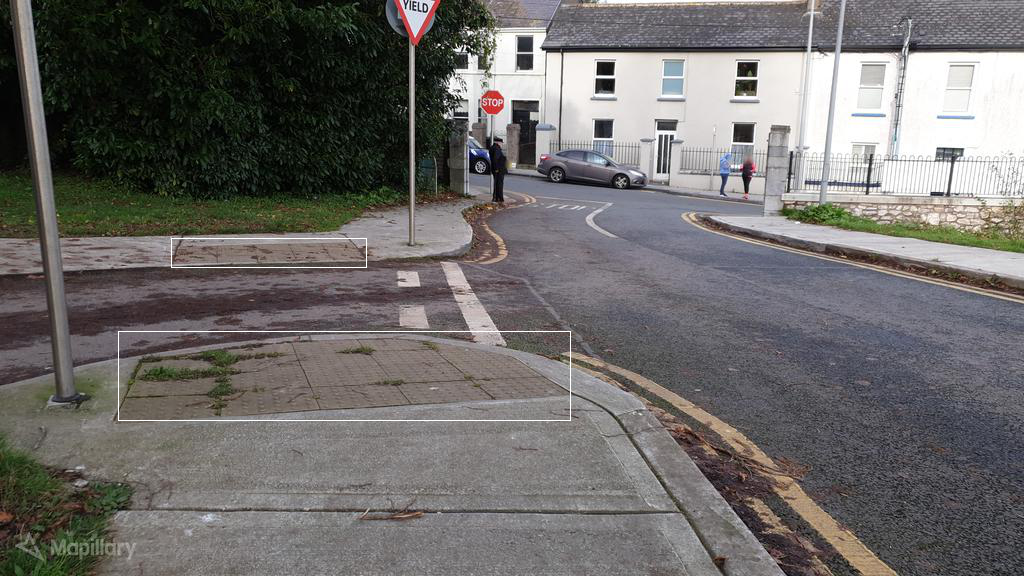

In [191]:
image_id = np.random.randint(0, len(images))

corresponding_dicts = [d for d in annotations["annotations"] if d["image_id"] == image_id]

draw_bbox(images[image_id], corresponding_dicts)

Nice!

In [102]:
feature_extractor = DetrFeatureExtractor.from_pretrained("facebook/detr-resnet-50")

model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50")

In [54]:
image = Image.open(
    "crowd4access-images/crowd4access-images/trainval/image/" + os.listdir("crowd4access-images/crowd4access-images/trainval/image")[0]
)

In [55]:
inputs = feature_extractor(images=image, return_tensors="pt")
outputs = model(**inputs)

/home/dadofapollo/miniconda3/envs/tactile-paving/lib/python3.7/site-packages/transformers/models/detr/modeling_detr.py:422: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  dim_t = self.temperature ** (2 * (dim_t // 2) / self.embedding_dim)
